<a href="https://www.kaggle.com/code/adityavardhanms/rice-leaf-disease-detection?scriptVersionId=221764979" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    print("Name:", gpu.name, "  Type:", gpu.device_type)

tf.test.is_gpu_available()

strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy()
print("Number of accelerators: ", strategy.num_replicas_in_sync)
batch_size = 32 * strategy.num_replicas_in_sync


Name: /physical_device:GPU:0   Type: GPU
Name: /physical_device:GPU:1   Type: GPU
Number of accelerators:  2


In [3]:
from itertools import chain

In [4]:
aug_gen =  tf.keras.preprocessing.image.ImageDataGenerator(shear_range=0.2,zoom_range=0.2,rotation_range=20,horizontal_flip=True,fill_mode='constant',width_shift_range=0.2,  
            height_shift_range=0.2)
aug_dataset = aug_gen.flow_from_directory(
    '/kaggle/input/extracted-dataset2/Extracted_dataset-2/train',
    target_size=(224,224),
    color_mode='rgb',
    classes=None,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=1,
    interpolation='nearest',
    keep_aspect_ratio=False
)
train_gen =  tf.keras.preprocessing.image.ImageDataGenerator()
train_dataset=train_gen.flow_from_directory(
    '/kaggle/input/extracted-dataset2/Extracted_dataset-2/train',
    target_size=(224,224),
    color_mode='rgb',
    classes=None,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=10,
    interpolation='nearest',
    keep_aspect_ratio=False
)

val_gen = tf.keras.preprocessing.image.ImageDataGenerator()
val_dataset = val_gen.flow_from_directory(
    '/kaggle/input/extracted-dataset2/Extracted_dataset-2/test',
    target_size=(224,224),
    color_mode='rgb',
    classes=None,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=1,
    interpolation='nearest',
    keep_aspect_ratio=False
)



Found 2878 images belonging to 9 classes.
Found 2878 images belonging to 9 classes.
Found 710 images belonging to 9 classes.


In [5]:
steps_per_epoch =(2*2878)//batch_size
validation_steps = 710//batch_size

In [6]:

dataset = chain(train_dataset,aug_dataset)

In [7]:
with strategy.scope():
    def f1_metric(y_true,y_pred):
        tp = tf.reduce_sum(y_true * tf.round(y_pred), axis=0)
        fp = tf.reduce_sum(tf.round(y_pred) - y_true, axis=0)
        fn = tf.reduce_sum(y_true - tf.round(y_pred), axis=0)

        precision = tp / (tp + fp + tf.keras.backend.epsilon())
        recall = tp / (tp + fn + tf.keras.backend.epsilon())

        f1 = 2 * precision * recall / (precision + recall + tf.keras.backend.epsilon())
        macro_f1 = tf.reduce_mean(f1)
        return macro_f1
    def model():
        pre = tf.keras.applications.mobilenet.MobileNet(include_top=False,weights='imagenet',input_shape=(224,224,3))
        pre.trainable=True
        
        inputs = tf.keras.Input(shape=(224,224,3),name='input')
        X = tf.keras.applications.mobilenet.preprocess_input(inputs)
        X = pre(X)
       
        X = tf.keras.layers.GlobalMaxPooling2D()(X)
        outputs = tf.keras.layers.Dense(units=9,activation='softmax')(X)
        model = tf.keras.Model(inputs, outputs)
        model.summary()
        return model

    conv_model = model()
    conv_model.compile(optimizer = tf.keras.optimizers.Adam(), loss = tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy',f1_metric])

17225924/17225924 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_max_pooling2d (Globa  (None, 1024)             0      

In [8]:
history = conv_model.fit(dataset, validation_data =val_dataset, steps_per_epoch=steps_per_epoch,validation_steps=validation_steps,epochs=5, verbose=1,callbacks=[tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.9,patience=3, verbose=1,min_delta=0.0001,min_lr=0.000001),tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=10,verbose=1, mode="auto",restore_best_weights=True)])

Epoch 1/5
89/89 [==============================] - 162s 1s/step - loss: 1.1622 - accuracy: 0.7963 - f1_metric: 0.9164 - val_loss: 1.3756 - val_accuracy: 0.6960 - val_f1_metric: 0.8030 - lr: 0.0010
Epoch 2/5
89/89 [==============================] - 110s 1s/step - loss: 0.4673 - accuracy: 0.9067 - f1_metric: 0.9588 - val_loss: 0.6273 - val_accuracy: 0.8793 - val_f1_metric: 0.9545 - lr: 0.0010
Epoch 3/5
89/89 [==============================] - 108s 1s/step - loss: 0.3385 - accuracy: 0.9345 - f1_metric: 0.9625 - val_loss: 0.6390 - val_accuracy: 0.8977 - val_f1_metric: 0.9394 - lr: 0.0010
Epoch 4/5
89/89 [==============================] - 108s 1s/step - loss: 0.1896 - accuracy: 0.9591 - f1_metric: 0.9700 - val_loss: 0.6665 - val_accuracy: 0.8849 - val_f1_metric: 0.9697 - lr: 0.0010
Epoch 5/5
89/89 [==============================] - ETA: 0s - loss: 0.1838 - accuracy: 0.9628 - f1_metric: 0.9738
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0009000000427477062.
89/89 [================

In [9]:
model_json = conv_model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

conv_model.save_weights("RC.h5")

In [10]:
conv_model.save("RC1.h5")

In [11]:
conv_model.evaluate(val_dataset)

12/12 [==============================] - 12s 979ms/step - loss: 1.3394 - accuracy: 0.8239 - f1_metric: 0.8981


[1.33938729763031, 0.8239436745643616, 0.898148238658905]

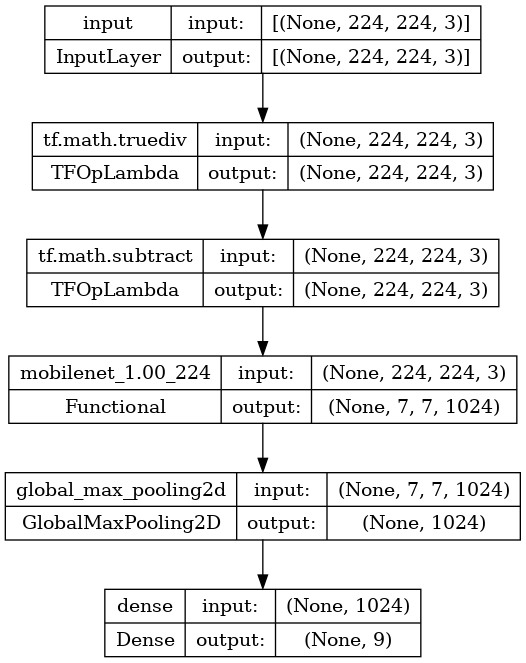

In [12]:
from keras.utils.vis_utils import plot_model
plot_model(conv_model, to_file='model.png', show_shapes=True)

In [13]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
#model = tf.keras.models.load_model('RC.h5')

# Load and preprocess the test image
# Replace 'test_image.jpg' with the actual path to your test image
image_path = '/kaggle/input/extracted-dataset2/Extracted_dataset-2/test/narrow_brown_spot/narrow_brown_val (13).jpg'
image_size = (224, 224)  # Replace with the input size used during model training

# Load the image
img = load_img(image_path, target_size=image_size)

# Convert the image to array
img_array = img_to_array(img)

# Normalize the image
img_array = img_array / 255.0  # Ensure the model was trained with normalized data

# Add a batch dimension
img_array = np.expand_dims(img_array, axis=0)

# Predict the class of the image
predictions = conv_model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)[0]  # Get the predicted class index

# Define class labels (replace with your actual class names)
class_labels = ['Healthy', 'Brown_spot', 'Hispa','Tungro','Shath Blight', "leaf_blast",'leaf_scald','narrow_brown_spot','bacterial_leaf_blight']  # Example classes

# Display the prediction
print(f"Predicted Class: {class_labels[predicted_class]}")

1/1 [==============================] - 1s 1s/step
Predicted Class: bacterial_leaf_blight
